In [65]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from plane_nerf.inerf_trainer import load_data_into_trainer
from plane_nerf.inerf_utils import inerf
from plane_nerf.inerf_utils import load_eval_image_into_pipeline


In [67]:
os.chdir('/workspace/plane-nerf')
MODEL_PATH = "/workspace/plane-nerf/outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-03-20_224232"
DATA_PATH = "/workspace/plane-nerf/data/jackal_one_frame_color_wheel"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )
transform_file_path = "transforms.json"
with open(os.path.join(DATA_PATH, transform_file_path)) as f:
    transform = json.load(f)

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,transform)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"

tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Fal

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-03-20_224232/nerfstudio_models/step-000009999.ckpt

Setting up training dataset...

Caching all 1 images.

Loading PlaneNerfCameraOptimizer


[07:43:33] Saving checkpoints to:                                                                         ]8;id=150373;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=829744;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-03-20_224232/nerfstudio_models                    

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_color_wheel_training_data_1/plane-nerf/2024-03-20_224232/nerfstudio_models/step-000009999.ckpt

In [68]:
with open(GROUND_TRUTH_PATH) as f:
    ground_truth_transform = json.load(f)
ground_truth_poses = []
tf = ground_truth_transform["frames"][0]["transform_matrix"]
tf = np.asarray(tf)
tf = tf[:3, :4 ]
ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(trainer.pipeline.device)

In [69]:
import time
start = time.time()
ans = inerf(trainer,ITERATION=500, LR = 1e-2, GROUND_TRUTH_POSE=ground_truth_poses)
end = time.time()
print("Time taken for inference: ", end-start)

Number of keypoints:  86
Number of rays:  3615
Randomly select more rays
Final number of rays:  4096
Time taken for inference:  63.12957310676575


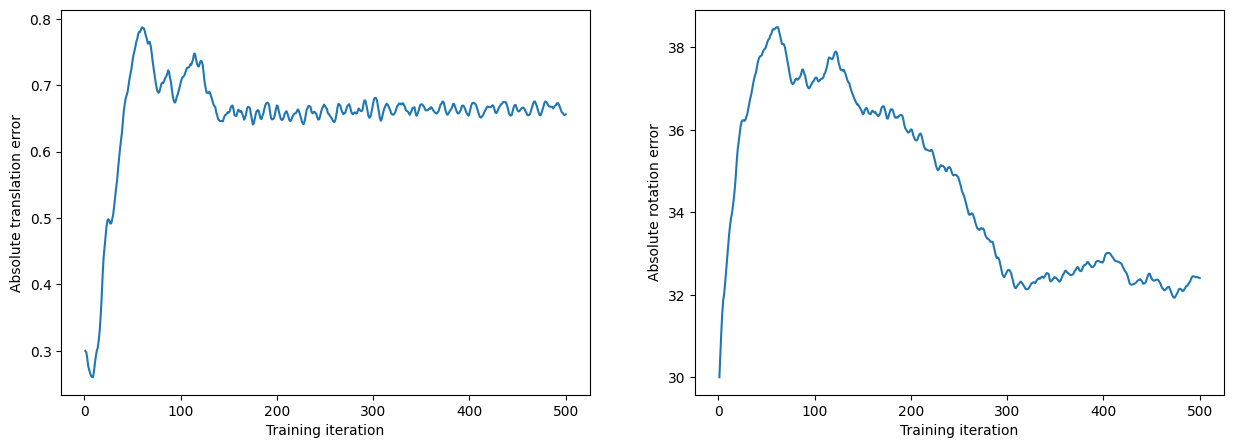

In [70]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots

plotting_data = np.asarray(ans["store"].to("cpu"))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(plotting_data[:, 0], plotting_data[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(plotting_data[:, 0], plotting_data[:, 2]*180/np.pi)
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()

In [71]:
print(ans["store"])

tensor([[1.0000e+00, 3.0000e-01, 5.2360e-01],
        [2.0000e+00, 2.9806e-01, 5.3360e-01],
        [3.0000e+00, 2.8959e-01, 5.4279e-01],
        ...,
        [4.9800e+02, 6.5555e-01, 5.6586e-01],
        [4.9900e+02, 6.5527e-01, 5.6572e-01],
        [5.0000e+02, 6.5596e-01, 5.6555e-01]], dtype=torch.float64)
